In [80]:
import scipy
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymatch
from pymatch.Matcher import Matcher
import sys, re, platform, glob
from tqdm.autonotebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Fixed seed for reproducibility
np.random.seed(11072021)

print(f"Python version: {sys.version}")
print(f"OS version: {platform.platform()}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"statsmodels version: {statsmodels.__version__}")

Python version: 3.7.5 (v3.7.5:5c02a39a0b, Oct 14 2019, 18:49:57) 
[Clang 6.0 (clang-600.0.57)]
OS version: Darwin-20.2.0-x86_64-i386-64bit
pandas version: 1.3.0
numpy version: 1.21.0
scipy version: 1.7.0
statsmodels version: 0.12.2


## Analysis

### Loading VAERS data

Note: for legal reasons, we cannot reproduce the raw VAERS data in Github. However, you can download the VAERS data set
from [HHS](https://vaers.hhs.gov).

In [81]:
%%time

path = "../data/" # use your path
vaccine_files = glob.glob(path + "*VAERSVAX.csv")

vax_frames = []

for filename in tqdm(vaccine_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    vax_frames.append(df)

vax = pd.concat(vax_frames, axis=0, ignore_index=True)[["VAERS_ID", "VAX_TYPE", "VAX_DOSE_SERIES", "VAX_NAME"]]

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 1.22 s, sys: 481 ms, total: 1.7 s
Wall time: 1.8 s


In [82]:
%%time

recipient_files = glob.glob(path + "*VAERSDATA.csv")

recipient_frames = []

for filename in tqdm(recipient_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    recipient_frames.append(df)

recipients = pd.concat(recipient_frames, axis=0, ignore_index=True)


  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 8.69 s, sys: 2.27 s, total: 11 s
Wall time: 11.3 s


In [83]:
%%time

symptoms_files = glob.glob(path + "*VAERSSYMPTOMS.csv")

symptoms_frames = []

for filename in tqdm(symptoms_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    symptoms_frames.append(df)

symptoms = pd.melt(pd.concat(symptoms_frames, axis=0, ignore_index=True)[["VAERS_ID", "SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]],
               id_vars="VAERS_ID",
               value_vars=(f"SYMPTOM{i}" for i in range(1, 6))).drop("variable", axis=1)

symptoms.columns = ("VAERS_ID", "SYMPTOM")
symptoms = symptoms.dropna()

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 2.22 s, sys: 703 ms, total: 2.92 s
Wall time: 3.17 s


### Merge data frames

In [84]:
%%time

data = vax.merge(recipients).merge(symptoms)

print(f"Imported {data.VAERS_ID.unique().shape[0]:,} reports.")


Imported 1,018,240 reports.
CPU times: user 6.05 s, sys: 2.69 s, total: 8.74 s
Wall time: 9.48 s


### Filtering reports

#### Filtering unknown ages and genders

In [85]:
v_0 = data.VAERS_ID.unique().shape[0]
data = data.dropna(subset = ["AGE_YRS"])
v_1 = data.VAERS_ID.unique().shape[0]
data = data[data.SEX.isin(["M", "F"])]
v_2 = data.VAERS_ID.unique().shape[0]

print(f"Discarded {v_1 - v_0:,} reports for unknown age.")
print(f"Discarded {v_2 - v_1:,} reports for unreported or unknown gender.")

Discarded -140,270 reports for unknown age.
Discarded -18,974 reports for unreported or unknown gender.



#### Filter unknown vaccines and unknown COVID vaccines

In [86]:
v_0 = data.VAERS_ID.unique().shape[0]
data = data[data.VAX_TYPE != "UNK"]
v_1 = data.VAERS_ID.unique().shape[0]
data = data[data.VAX_NAME != "COVID19 (COVID19 (UNKNOWN))"]
v_2 = data.VAERS_ID.unique().shape[0]

print(f"Discarded {v_1 - v_0:,} reports for unknown vaccine type.")
print(f"Discarded {v_2 - v_1:,} reports for unknown COVID-19 vaccine subclass.")

Discarded -4,660 reports for unknown vaccine type.
Discarded -744 reports for unknown COVID-19 vaccine subclass.


### Classifying cases and controls

In [87]:
anaphylactic_presentations = [
    "Anaphylactic shock",
    "Anaphylactic reaction",
    "Anaphylactoid shock",
    "Anaphylactoid reaction"
]

In [88]:
%%time

data["IS_ANAPHYLACTIC"] = data.SYMPTOM.isin(anaphylactic_presentations)
data["IS_ANAPHYLACTIC"] = data.groupby("VAERS_ID").agg({"IS_ANAPHYLACTIC": np.max})

print(f"{data[data.IS_ANAPHYLACTIC == True].groupby('VAERS_ID').VAERS_ID.unique().shape[0]} cases identified.")
print(f"{data[data.IS_ANAPHYLACTIC == False].groupby('VAERS_ID').VAERS_ID.unique().shape[0]} possible controls identified.")

2217 cases identified.
156591 possible controls identified.
CPU times: user 9.63 s, sys: 962 ms, total: 10.6 s
Wall time: 10.5 s


### Classifying cases and controls by mRNA status

In [89]:
data["IS_MRNA_VACCINE"] = data.VAX_NAME.isin(["COVID19 (COVID19 (PFIZER-BIONTECH))",
                                              "COVID19 (COVID19 (MODERNA))"])

In [90]:
pd.crosstab(data.IS_MRNA_VACCINE, data.IS_ANAPHYLACTIC).sort_index(ascending=False).sort_index(axis=1, ascending=False)

IS_ANAPHYLACTIC,True,False
IS_MRNA_VACCINE,,
True,88,24865
False,2234,729280


### Crude odds ratio (before matching)

In [91]:
contingency_table = sm.stats.Table2x2(pd.crosstab(data.IS_MRNA_VACCINE, data.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))

print(f"Crude OR for anaphylaxis: {contingency_table.oddsratio:.3f} @ p = {contingency_table.oddsratio_pvalue()}")
print(f"CI: {contingency_table.oddsratio_confint()[0]:.3f} –– {contingency_table.oddsratio_confint()[1]:.3f}")

Crude OR for anaphylaxis: 1.155 @ p = 0.18477368357049306
CI: 0.933 –– 1.430


### Matching

In [92]:
cases = data[data.IS_ANAPHYLACTIC == True][["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_MRNA_VACCINE"]]
controls = data[data.IS_ANAPHYLACTIC == False][["VAERS_ID", "AGE_YRS", "SEX", "IS_ANAPHYLACTIC", "IS_MRNA_VACCINE"]]

In [93]:
m = Matcher(cases, controls, yvar="IS_ANAPHYLACTIC", exclude=["VAERS_ID", "IS_MRNA_VACCINE"])

Formula:
IS_ANAPHYLACTIC ~ AGE_YRS+SEX
n majority: 754145
n minority: 2322


In [94]:
%%time

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 52.22%
CPU times: user 29.2 s, sys: 5.3 s, total: 34.5 s
Wall time: 8.89 s


In [95]:
%%time

m.predict_scores()

CPU times: user 6.26 s, sys: 1.38 s, total: 7.64 s
Wall time: 2.01 s


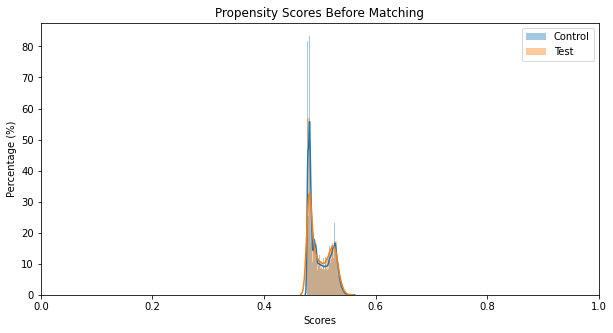

In [96]:
m.plot_scores()
plt.savefig("../writeup/propensity_scores.pdf")

In [97]:
%%time

m.match(method="random", nmatches=3)

CPU times: user 15.8 s, sys: 494 ms, total: 16.3 s
Wall time: 16.4 s


In [98]:
%%time

m.record_frequency()

CPU times: user 10.2 ms, sys: 3.97 ms, total: 14.1 ms
Wall time: 12.5 ms


,freq,n_records
0,1,8516
1,2,28


In [99]:
%%time

m.assign_weight_vector()

CPU times: user 11.1 ms, sys: 1.95 ms, total: 13 ms
Wall time: 11.6 ms


In [100]:
m.matched_data.shape

(8572, 9)

In [101]:
df = m.matched_data.merge(data[["VAERS_ID", "IS_MRNA_VACCINE"]]).groupby(["record_id", "match_id"]).first()

In [102]:
df = df.reset_index()

In [103]:
matched_df = df.merge(data[["VAERS_ID", "ALLERGIES"]]).groupby("VAERS_ID").first()


### Anaphylaxis OR for all COVID-19 vaccines

In [104]:
pd.crosstab(matched_df.IS_MRNA_VACCINE, matched_df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)

IS_ANAPHYLACTIC,True,False
IS_MRNA_VACCINE,,
True,88,204
False,2129,5581


In [105]:
contingency_table = sm.stats.Table2x2(pd.crosstab(matched_df.IS_MRNA_VACCINE, matched_df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False))

print(f"OR for anaphylaxis: {contingency_table.oddsratio:.3f} @ p = {contingency_table.oddsratio_pvalue()}")
print(f"CI: {contingency_table.oddsratio_confint()[0]:.3f} –– {contingency_table.oddsratio_confint()[1]:.3f}")

OR for anaphylaxis: 1.131 @ p = 0.3445419627005407
CI: 0.876 –– 1.459


### Odds ratios by gender

#### Crude

In [106]:
odds_ratios_by_gender_crude = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

for gender in tqdm(data.SEX.unique()):
    df = data[data.SEX == gender]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        if xt[True][True] > 10:
            ct = sm.stats.Table2x2(xt)
            odds_ratios_by_gender_crude.loc[gender, "ROR"] = ct.oddsratio
            odds_ratios_by_gender_crude.loc[gender, "p_value"] = ct.oddsratio_pvalue()
            odds_ratios_by_gender_crude.loc[gender, "95CI_lower"] = ct.oddsratio_confint()[0]
            odds_ratios_by_gender_crude.loc[gender, "95CI_upper"] = ct.oddsratio_confint()[1]
            odds_ratios_by_gender_crude.loc[gender, "a"] = xt[True][True]
            odds_ratios_by_gender_crude.loc[gender, "b"] = xt[False][True]
            odds_ratios_by_gender_crude.loc[gender, "c"] = xt[True][False]
            odds_ratios_by_gender_crude.loc[gender, "d"] = xt[False][False]
    except KeyError:
        continue

  0%|          | 0/2 [00:00<?, ?it/s]

In [107]:
odds_ratios_by_gender_crude

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
F,1.056563,0.658357,0.827903,1.348377,68.0,20531.0,1377.0,439269.0
M,1.561618,0.049301,1.001364,2.435328,20.0,4334.0,857.0,290011.0


In [108]:
stratified_contingency_of_genders_crude = list()

for stratum in odds_ratios_by_gender_crude.index:
    stratified_contingency_of_genders_crude.append([[odds_ratios_by_gender_crude.loc[stratum, "a"], odds_ratios_by_gender_crude.loc[stratum, "b"]], [odds_ratios_by_gender_crude.loc[stratum, "c"], odds_ratios_by_gender_crude.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_genders_crude)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.143   0.922 1.415
Pooled log odds       0.133  -0.081 0.347
Pooled risk ratio     1.142              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         1.496   0.221 
Test constant OR     2.310   0.129 
                         
-------------------------
Number of tables      2  
Min n            295222  
Max n            461245  
Avg n            378234  
Total n          756467  
-------------------------


#### Adjusted for age and gender

In [109]:
odds_ratios_by_gender = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

for gender in tqdm(matched_df.SEX.unique()):
    df = matched_df[matched_df.SEX == gender]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        if xt[True][True] > 10:
            ct = sm.stats.Table2x2(xt)
            odds_ratios_by_gender.loc[gender, "ROR"] = ct.oddsratio
            odds_ratios_by_gender.loc[gender, "p_value"] = ct.oddsratio_pvalue()
            odds_ratios_by_gender.loc[gender, "95CI_lower"] = ct.oddsratio_confint()[0]
            odds_ratios_by_gender.loc[gender, "95CI_upper"] = ct.oddsratio_confint()[1]
            odds_ratios_by_gender.loc[gender, "a"] = xt[True][True]
            odds_ratios_by_gender.loc[gender, "b"] = xt[False][True]
            odds_ratios_by_gender.loc[gender, "c"] = xt[True][False]
            odds_ratios_by_gender.loc[gender, "d"] = xt[False][False]
    except KeyError:
        continue

  0%|          | 0/2 [00:00<?, ?it/s]

In [110]:
odds_ratios_by_gender

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
M,1.620514,0.093742,0.921458,2.8499,20.0,32.0,808.0,2095.0
F,1.04329,0.77289,0.782365,1.391235,68.0,172.0,1321.0,3486.0


In [111]:
stratified_contingency_of_genders = list()

for stratum in odds_ratios_by_gender.index:
    stratified_contingency_of_genders.append([[odds_ratios_by_gender.loc[stratum, "a"], odds_ratios_by_gender.loc[stratum, "b"]], [odds_ratios_by_gender.loc[stratum, "c"], odds_ratios_by_gender.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_genders)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.137   0.881 1.468
Pooled log odds       0.129  -0.127 0.384
Pooled risk ratio     1.096              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         0.974   0.324 
Test constant OR     1.872   0.171 
                       
-----------------------
Number of tables    2  
Min n            2955  
Max n            5047  
Avg n            4001  
Total n          8002  
-----------------------


### Odds ratios by age band

#### Crude

In [112]:
data["age_band"] = pd.cut(data.AGE_YRS,
                          bins=(0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 120),
                          labels=("<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95", ">95"),
                          right=True)

data = data.dropna(subset = ["age_band"])

matched_df["age_band"] = pd.cut(matched_df.AGE_YRS,
                          bins=(0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 120),
                          labels=("<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95", ">95"),
                          right=True)

In [113]:
odds_ratios_by_age_band_crude = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper", "a", "b", "c", "d"))

In [114]:
for age_band in tqdm(data.age_band.unique()):
    try:
        df = data[data["age_band"] == age_band]
        xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_age_band_crude.loc[age_band, "ROR"] = ct.oddsratio
        odds_ratios_by_age_band_crude.loc[age_band, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_age_band_crude.loc[age_band, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_age_band_crude.loc[age_band, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_age_band_crude.loc[age_band, "a"] = xt[True][True]
        odds_ratios_by_age_band_crude.loc[age_band, "b"] = xt[False][True]
        odds_ratios_by_age_band_crude.loc[age_band, "c"] = xt[True][False]
        odds_ratios_by_age_band_crude.loc[age_band, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

In [115]:
odds_ratios_by_age_band_crude

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
<18,3.093905,0.426598,0.191104,50.089305,0,58,1074,385451
66-75,2.384584,0.055496,0.979789,5.803535,5,634,230,69544
76-85,1.655065,0.61765,0.228914,11.966245,1,175,77,22302
26-35,0.800278,0.371303,0.491043,1.304255,18,6466,157,45134
56-65,1.252364,0.398956,0.742403,2.112621,15,3621,237,71650
86-95,1.931777,0.648351,0.114029,32.72656,0,78,14,4219
19-25,1.356552,0.40433,0.662473,2.777822,8,1769,123,36896
36-45,1.127431,0.588871,0.72978,1.741757,24,6656,135,42211
46-55,0.885172,0.630943,0.538157,1.455951,17,5354,184,51295


In [116]:
stratified_contingency_of_age_bands_crude = list()

for stratum in odds_ratios_by_age_band_crude.index:
    stratified_contingency_of_age_bands_crude.append([[odds_ratios_by_age_band_crude.loc[stratum, "a"], odds_ratios_by_age_band_crude.loc[stratum, "b"]], [odds_ratios_by_age_band_crude.loc[stratum, "c"], odds_ratios_by_age_band_crude.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_age_bands_crude)

print(st.summary())


                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.055   0.846 1.315
Pooled log odds       0.054  -0.167 0.274
Pooled risk ratio     1.055              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         0.228   0.633 
Test constant OR     6.753   0.563 
                         
-------------------------
Number of tables      9  
Min n              4311  
Max n            386583  
Avg n             83981  
Total n          755832  
-------------------------


#### Adjusted for age and gender

In [117]:
odds_ratios_by_age_band = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper", "a", "b", "c", "d"))

In [118]:
for age_band in tqdm(matched_df.age_band.unique()):
    try:
        df = matched_df[matched_df.age_band == age_band]
        xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_age_band.loc[age_band, "ROR"] = ct.oddsratio
        odds_ratios_by_age_band.loc[age_band, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_age_band.loc[age_band, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_age_band.loc[age_band, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_age_band.loc[age_band, "a"] = xt[True][True]
        odds_ratios_by_age_band.loc[age_band, "b"] = xt[False][True]
        odds_ratios_by_age_band.loc[age_band, "c"] = xt[True][False]
        odds_ratios_by_age_band.loc[age_band, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/11 [00:00<?, ?it/s]

In [119]:
odds_ratios_by_age_band

,ROR,p_value,95CI_lower,95CI_upper,a,b,c,d
56-65,1.854163,0.070105,0.950563,3.616717,15,23,223,634
46-55,0.878846,0.659892,0.494436,1.562123,17,52,170,457
76-85,1.361111,0.802473,0.121565,15.239718,1,2,72,196
66-75,3.207014,0.084496,0.853339,12.052581,5,4,221,567
36-45,1.020896,0.937121,0.610721,1.706552,24,60,134,342
26-35,0.84632,0.562769,0.480974,1.489184,18,54,154,391
19-25,2.444444,0.080798,0.89629,6.666714,8,8,117,286
86-95,1.576923,0.795915,0.04998,49.753416,0,1,13,41


In [120]:
stratified_contingency_of_age_bands = list()

for stratum in odds_ratios_by_age_band.index:
    stratified_contingency_of_age_bands.append([[odds_ratios_by_age_band.loc[stratum, "a"], odds_ratios_by_age_band.loc[stratum, "b"]], [odds_ratios_by_age_band.loc[stratum, "c"], odds_ratios_by_age_band.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_of_age_bands)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.143   0.878 1.489
Pooled log odds       0.134  -0.130 0.398
Pooled risk ratio     1.100              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         0.993   0.319 
Test constant OR     9.351   0.228 
                       
-----------------------
Number of tables    8  
Min n              55  
Max n             895  
Avg n             539  
Total n          4310  
-----------------------


#### Plot

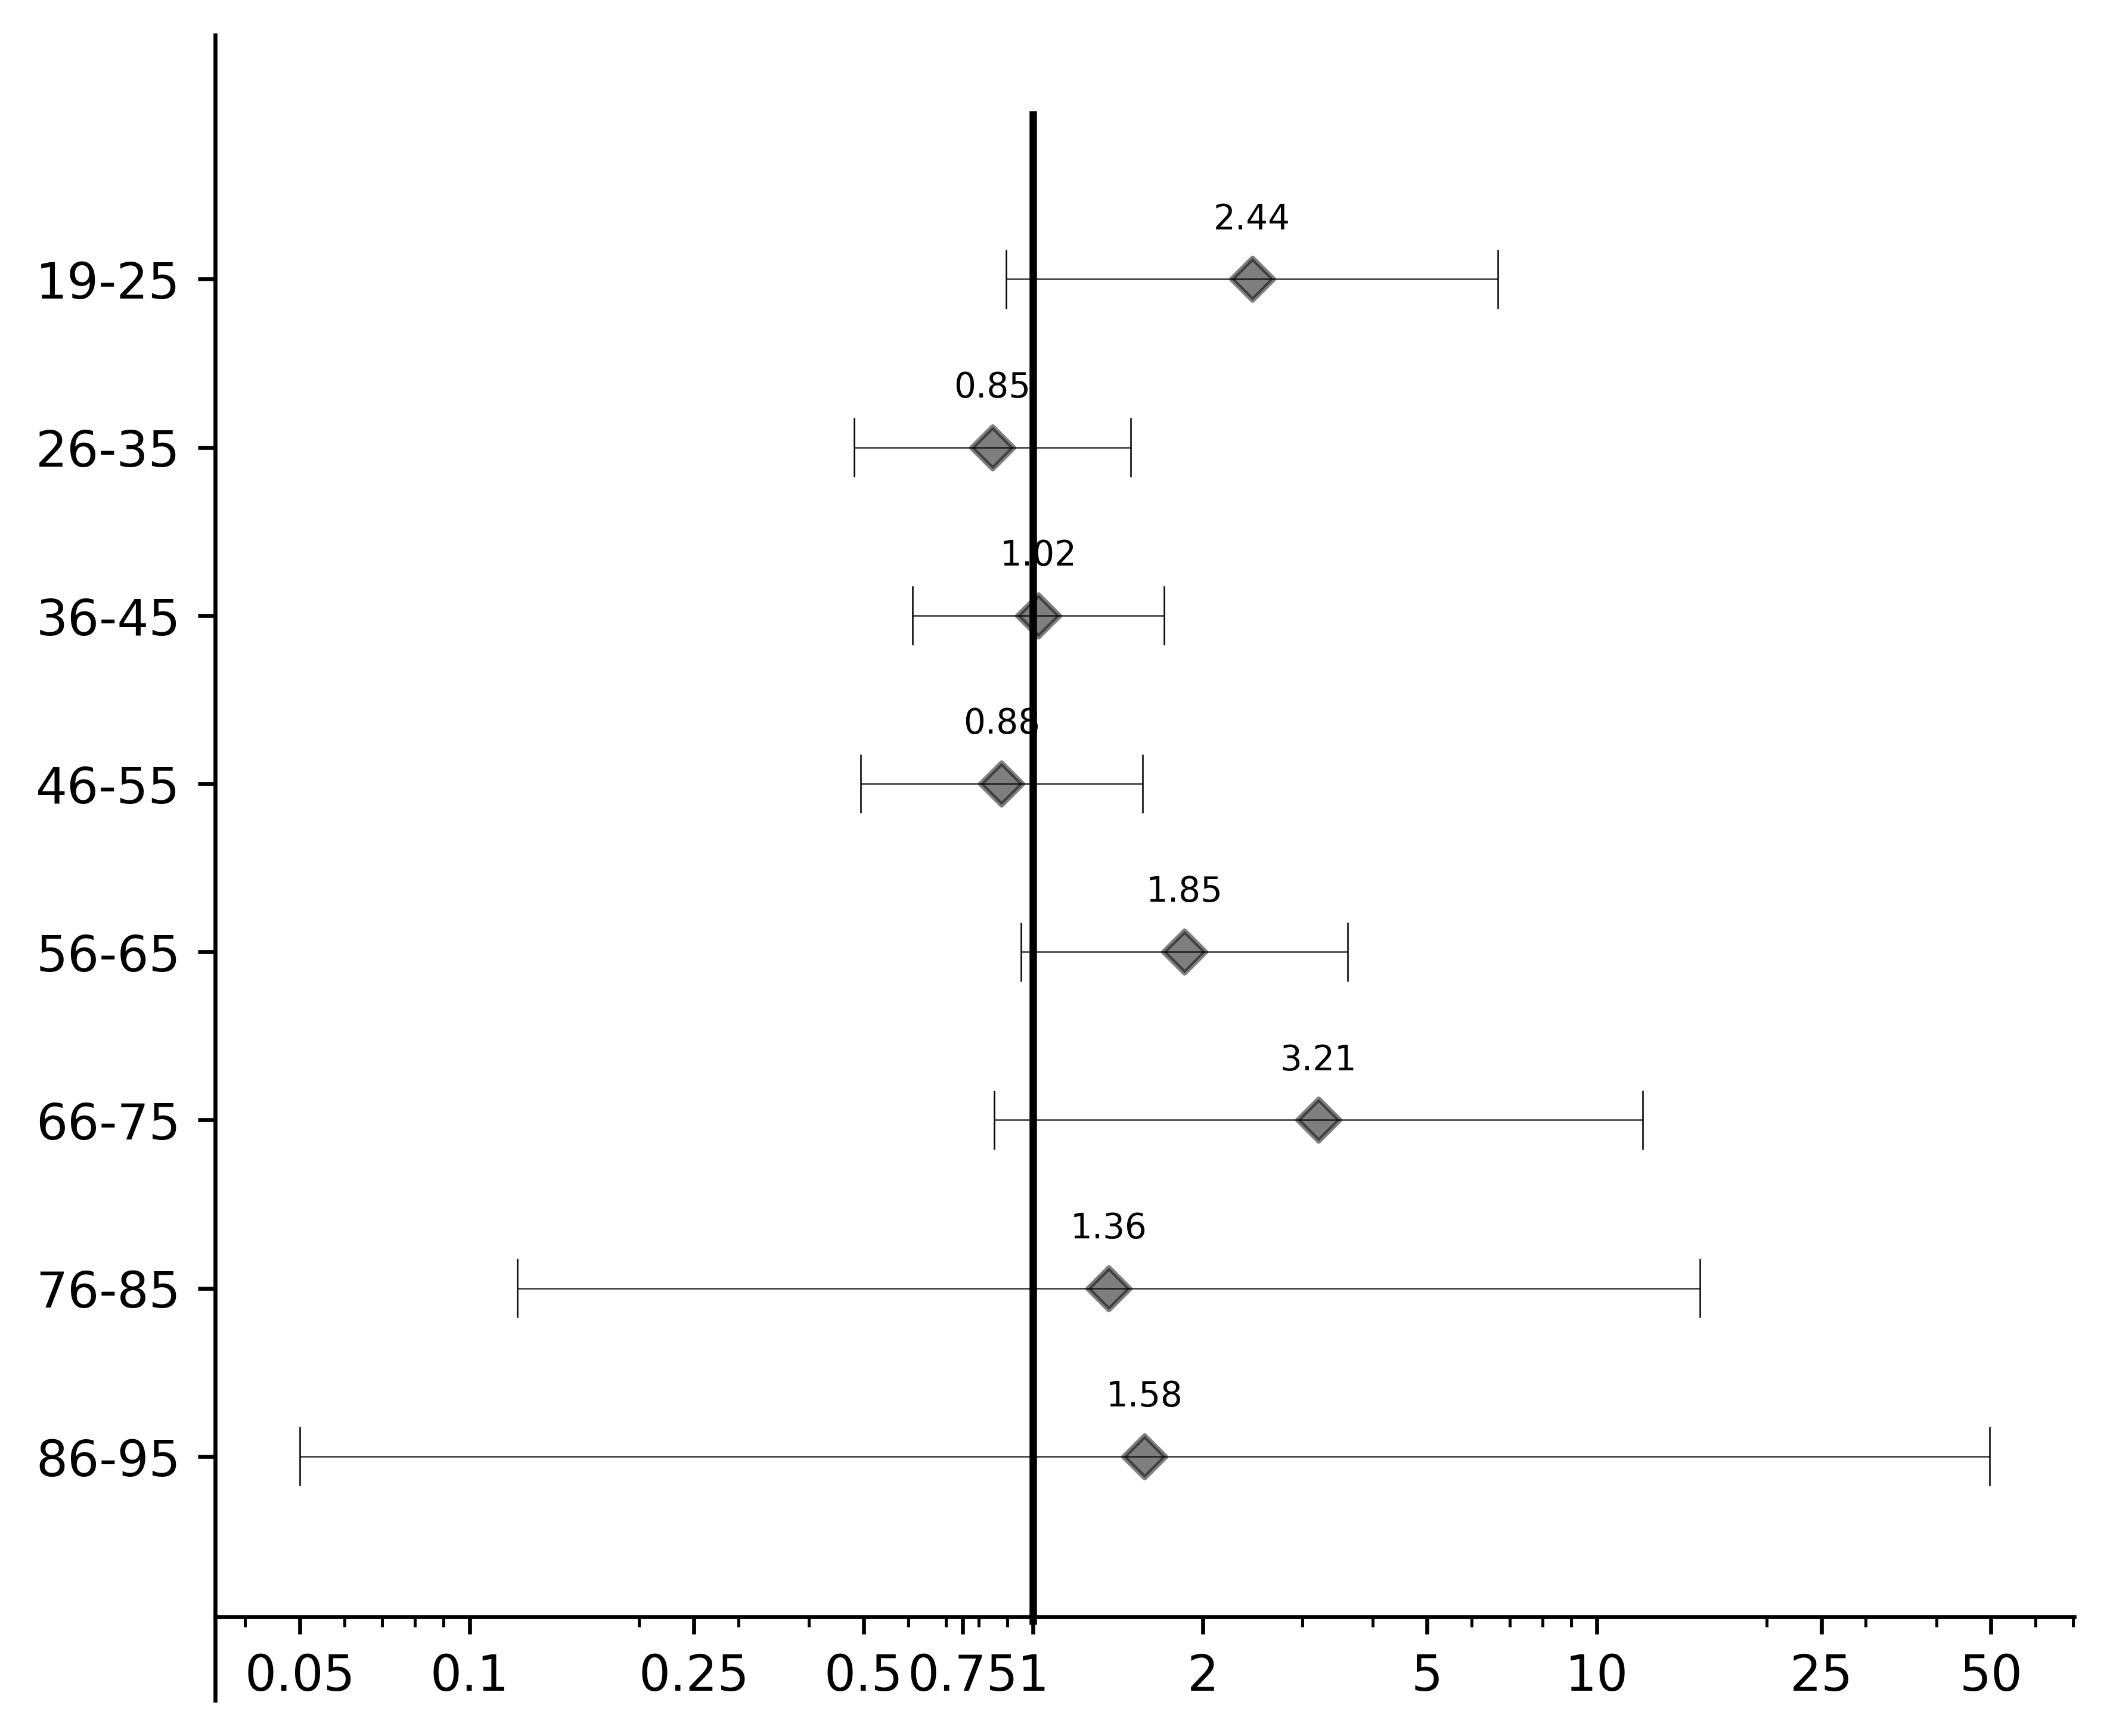

In [121]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(6, 5), dpi=600)

odds_ratios_by_age_band.index = pd.CategoricalIndex(odds_ratios_by_age_band.index,
                                                    categories = ["<18", "19-25", "26-35", "36-45", "46-55", "56-65", "66-75", "76-85", "86-95"],
                                                    ordered=True)

odds_ratios_by_age_band = odds_ratios_by_age_band.sort_index(ascending=False)

ax.scatter(odds_ratios_by_age_band.ROR, odds_ratios_by_age_band.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_age_band[odds_ratios_by_age_band.p_value < 0.05].ROR, odds_ratios_by_age_band[odds_ratios_by_age_band.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_age_band.index), colors="k")

for idx, val in enumerate(odds_ratios_by_age_band.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_age_band.loc[val, "95CI_lower"], xmax=odds_ratios_by_age_band.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_age_band.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_age_band.loc[val, "ROR"], s = f"{odds_ratios_by_age_band.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_age_band.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_age_band.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
#ax.set_xlim(4e-2, 4e0)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_age.pdf")

plt.show()


### Odds ratios by known allergies

In [122]:
extractors:dict = {
    "Opioids": r".*(cod(e)?(i|o)n(e)?|orphine|fenta|CDN|Demerol|contin|(o|i)cet|dilaud|methad|talwin|pentazocin(e)?).*",
    "Latex": r".*latex.*",
    "Macrolide and amino-\nglycoside antibiotics": r".*(mycin|Zithro|Z-pack|macroli|neosporin).*",
    "Tetracycline\nantibiotics": r".*(cycline).*",
    "Sulfas": r".*(sulf(a|ur|onam)|bactrim|sulfamet|SMX).*",
    "Beta-lactam\nantbiotics": r".*(pen(n)?(i|e)|keflex|ce(f|ph)a|cill(l)?in|augmentin|PCN|amox|roce(f|ph)).*",
    "Fluoroquinolone\nantibiotics": r".*(floxacin|cipro|quinolo).*",
    "HCTZ": ".*(h(ctz|ydrochlorothiazide)).*",
    "Glycols": r".*(PEG|(polyeth|prop)ylene glycol).*",
    "Local anaesthetics": r".*(caine).*",
    "Known vaccine\nhypersensitivities": r".*(va(x|cc)|bexsero|mmr|tetanus|tdap|dtap|prevnar|pneumovax|shingles|hepatitis).*",
    "Fish and/or\nseafood": r".*(fish|sea(\s)?food|mussels|crab|scallops).*",
    "Insect stings": r".*(bee|wasp|sting).*",
    "Eggs": r".*(egg).*",
    "NSAIDs": r".*(ibuprofen|motrin|advil|acetamino|nsaid|coxib|celebrex|APAP|as(a|pirin)|voltaren|naprox|to(d|r)olac|vioxx|mobic).*",
    "Peanuts and\ntree nuts": r".*(nut).*"
}

#### Crude

In [123]:
odds_ratios_by_preexisting_allergy_crude = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

all_allergics = data[["VAERS_ID", "IS_ANAPHYLACTIC", "IS_MRNA_VACCINE", "ALLERGIES"]].groupby("VAERS_ID").first().dropna()

for key in tqdm(extractors):
    df = all_allergics[all_allergics.ALLERGIES.str.match(re.compile(extractors[key], re.IGNORECASE))]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_preexisting_allergy_crude.loc[key, "ROR"] = ct.oddsratio
        odds_ratios_by_preexisting_allergy_crude.loc[key, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_preexisting_allergy_crude.loc[key, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "a"] = xt[True][True]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "b"] = xt[False][True]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "c"] = xt[True][False]
        odds_ratios_by_preexisting_allergy_crude.loc[key, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/16 [00:00<?, ?it/s]

In [124]:
stratified_contingency_by_preexisting_allergy_crude = list()

for stratum in odds_ratios_by_preexisting_allergy_crude.index:
    stratified_contingency_by_preexisting_allergy_crude.append([[odds_ratios_by_preexisting_allergy_crude.loc[stratum, "a"], odds_ratios_by_preexisting_allergy_crude.loc[stratum, "b"]], [odds_ratios_by_preexisting_allergy_crude.loc[stratum, "c"], odds_ratios_by_preexisting_allergy_crude.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_by_preexisting_allergy_crude)

print(st.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           0.522   0.227 1.202
Pooled log odds      -0.650  -1.483 0.184
Pooled risk ratio     0.523              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         2.476   0.116 
Test constant OR     7.198   0.783 
                        
------------------------
Number of tables    12  
Min n              370  
Max n             4740  
Avg n             1342  
Total n          16104  
------------------------


#### Adjusted for age and gender

In [125]:
odds_ratios_by_preexisting_allergy = pd.DataFrame(columns = ("ROR", "p_value", "95CI_lower", "95CI_upper"))

In [126]:
all_allergics = matched_df[["IS_ANAPHYLACTIC", "IS_MRNA_VACCINE", "ALLERGIES"]].dropna()

for key in tqdm(extractors):
    df = all_allergics[all_allergics.ALLERGIES.str.match(re.compile(extractors[key], re.IGNORECASE))]
    xt = pd.crosstab(df.IS_MRNA_VACCINE, df.IS_ANAPHYLACTIC).rename(columns={0: False, 1: True}).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    try:
        ct = sm.stats.Table2x2(xt)
        odds_ratios_by_preexisting_allergy.loc[key, "ROR"] = ct.oddsratio
        odds_ratios_by_preexisting_allergy.loc[key, "p_value"] = ct.oddsratio_pvalue()
        odds_ratios_by_preexisting_allergy.loc[key, "95CI_lower"] = ct.oddsratio_confint()[0]
        odds_ratios_by_preexisting_allergy.loc[key, "95CI_upper"] = ct.oddsratio_confint()[1]
        odds_ratios_by_preexisting_allergy.loc[key, "a"] = xt[True][True]
        odds_ratios_by_preexisting_allergy.loc[key, "b"] = xt[False][True]
        odds_ratios_by_preexisting_allergy.loc[key, "c"] = xt[True][False]
        odds_ratios_by_preexisting_allergy.loc[key, "d"] = xt[False][False]

    except ValueError:
        continue

  0%|          | 0/16 [00:00<?, ?it/s]

In [127]:

stratified_contingency_by_preexisting_allergy = list()

for stratum in odds_ratios_by_preexisting_allergy.index:
    stratified_contingency_by_preexisting_allergy.append([[odds_ratios_by_preexisting_allergy.loc[stratum, "a"], odds_ratios_by_preexisting_allergy.loc[stratum, "b"]], [odds_ratios_by_preexisting_allergy.loc[stratum, "c"], odds_ratios_by_preexisting_allergy.loc[stratum, "d"]]])

st = sm.stats.StratifiedTable(stratified_contingency_by_preexisting_allergy)

print(st.summary())


                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           1.486   0.992 2.227
Pooled log odds       0.396  -0.008 0.800
Pooled risk ratio     1.302              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1         3.742   0.053 
Test constant OR    15.390   0.221 
                      
----------------------
Number of tables  13  
Min n             25  
Max n            270  
Avg n             76  
Total n          989  
----------------------


#### Plot

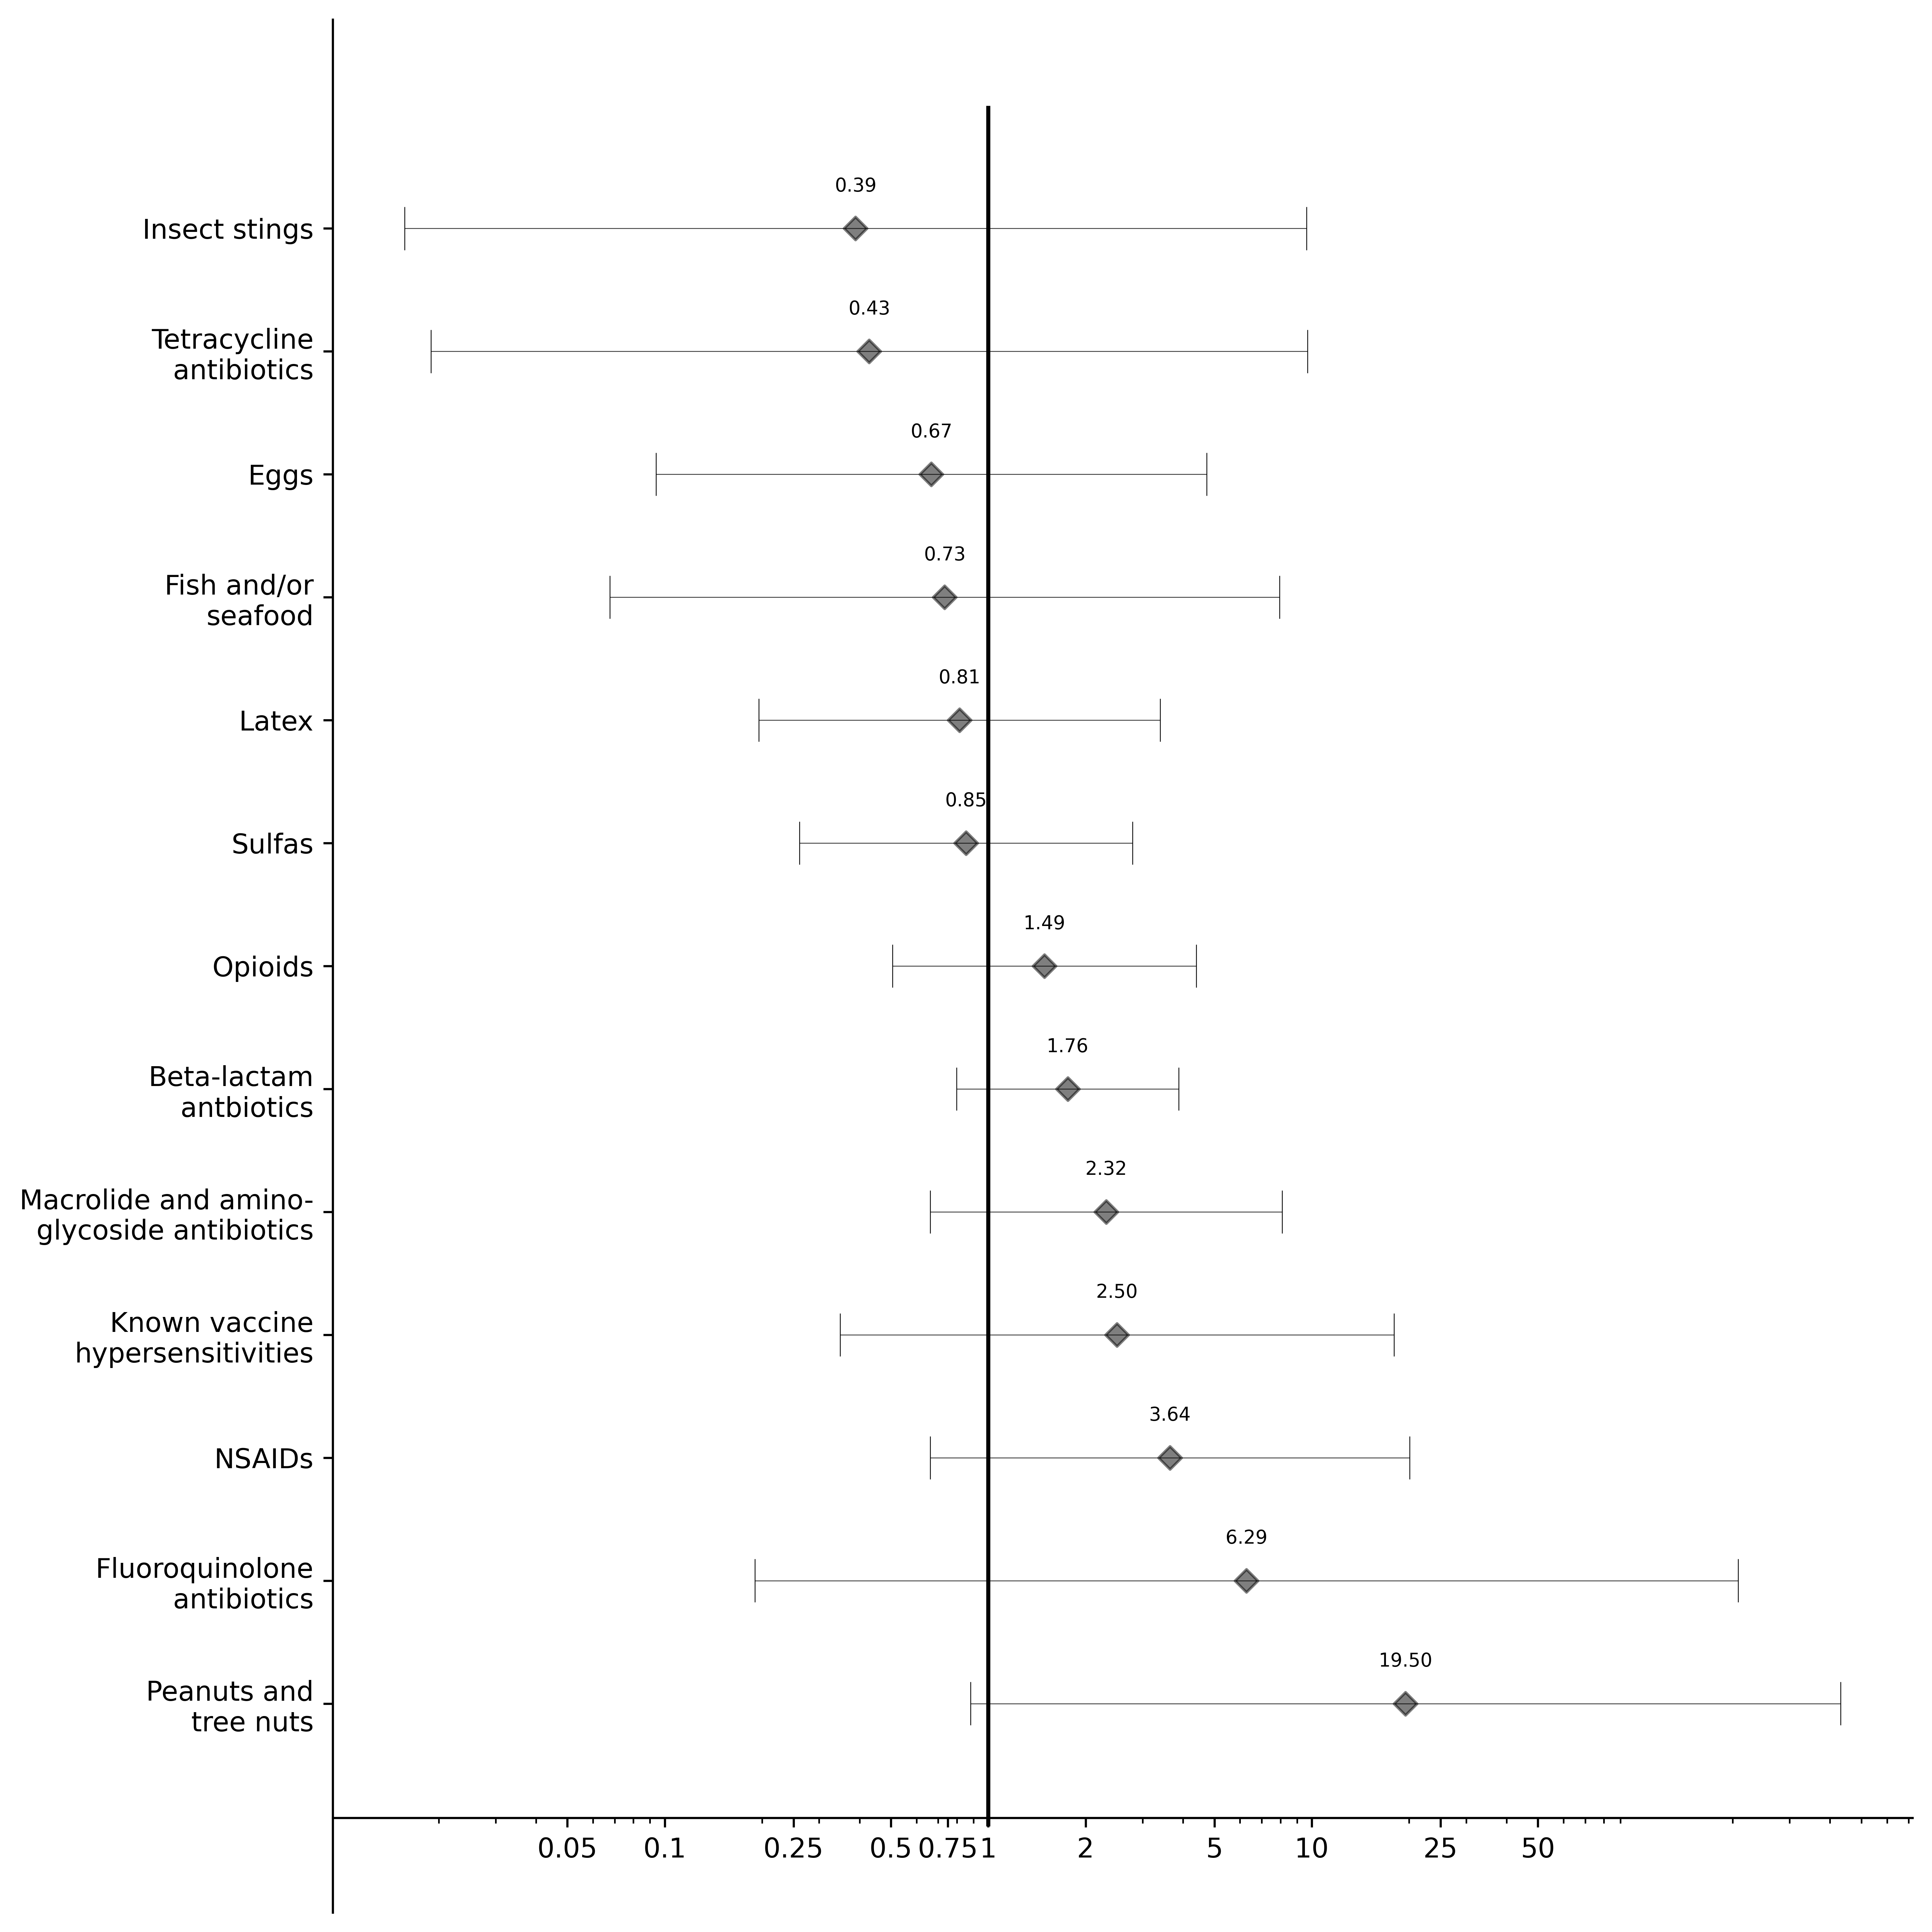

In [128]:
WHISKER:float = 0.175

fig, ax = plt.subplots(figsize=(10, 10), dpi=600)

odds_ratios_by_preexisting_allergy = odds_ratios_by_preexisting_allergy.sort_values("ROR", ascending=False)

ax.scatter(odds_ratios_by_preexisting_allergy.ROR, odds_ratios_by_preexisting_allergy.index, marker="D", color="k", alpha=0.5)
ax.scatter(odds_ratios_by_preexisting_allergy[odds_ratios_by_preexisting_allergy.p_value < 0.05].ROR, odds_ratios_by_preexisting_allergy[odds_ratios_by_preexisting_allergy.p_value < 0.05].index, marker="D", color="r", alpha=1.0)

ax.vlines(x=1, ymin=-1, ymax=len(odds_ratios_by_preexisting_allergy.index), colors="k")

for idx, val in enumerate(odds_ratios_by_preexisting_allergy.index):
    ax.hlines(y=idx, xmin=odds_ratios_by_preexisting_allergy.loc[val, "95CI_lower"], xmax=odds_ratios_by_preexisting_allergy.loc[val, "95CI_upper"], color="k", lw=0.3, alpha=0.8)
    pvalue_marker = "***" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.001 else ("**" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.005 else ("*" if odds_ratios_by_preexisting_allergy.loc[val, "p_value"] < 0.05 else ""))
    ax.text(y = idx + 0.3, x = odds_ratios_by_preexisting_allergy.loc[val, "ROR"], s = f"{odds_ratios_by_preexisting_allergy.loc[val, 'ROR']:.2f}{pvalue_marker}", horizontalalignment="center", fontsize="x-small")
    ax.vlines(x=odds_ratios_by_preexisting_allergy.loc[val, "95CI_lower"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)
    ax.vlines(x=odds_ratios_by_preexisting_allergy.loc[val, "95CI_upper"], ymin=idx-WHISKER, ymax=idx+WHISKER, color="k", lw=0.3)

ax.set_xscale("log")
#ax.set_xlim(4e-2, 2e1)

ax.spines.left.set_position(("axes", 0.0))
ax.spines.right.set_color("none")
ax.spines.bottom.set_position(("axes", 0.05))
ax.spines.top.set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xticks([0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])
ax.set_xticklabels([0.05, 0.10, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50])

plt.tight_layout()
plt.savefig("../writeup/forest_plot_of_anaphylaxis_by_known_allergies.pdf")

plt.show()

